<a href="https://colab.research.google.com/github/yeahzee0421/AI_2022/blob/main/PM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **예측보수 Predictive Maintenance**



> 고장 후 보수 / 정기적 보수 / 예측 보수




*   항공기 엔진 고장 시점 및 일정 기간 내 고장 발생 여부 예측
*   회귀 문제 or 분류 문제 



> 회귀 : 몇 번의 사이클 후에 고장 발생?


> 분류 : 특정한 사이클 수 이내에 고장이 발생?(이진 분류) / 여러 구간에서 고장 발생 여부 예측(다중 분류)






In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

**훈련 데이터**

정상 상태에서 시작하며 훈련 데이터의 경우 마지막 사이클이 고장난 시점이라고 간주 

In [2]:
path1 = 'http://azuremlsamples.azureml.net/templatedata/PM_train.txt'
df_train_raw = pd.read_csv(path1, sep = ' ', header=None)
print(df_train_raw.shape)
df_train_raw[:2]

(20631, 28)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN


In [3]:
# 불필요한 컬럼 삭제
df_train_raw.drop([26,27], axis=1, inplace=True)

- 설명

•	__id__: is the engine ID, ranging from 1 to 100  
•	__cycle__: per engine sequence, starts from 1 to the cycle number where failure had happened (trining data only)  
•	__setting1__ to __setting3__: engine operational settings  
•	__s1__ to __s21__: sensors measurements  


In [5]:
# 컬럼 이름
col_names = ['id','cycle','setting1','setting2','setting3',
             's1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

In [6]:
df_train_raw.columns = col_names
df_train_raw[185:195]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
185,1,186,0.0027,-0.0003,100.0,518.67,643.51,1595.16,1426.30,14.62,...,520.08,2388.25,8123.45,8.5227,0.03,397,2388,100.0,38.47,23.0564
186,1,187,-0.0047,-0.0000,100.0,518.67,643.32,1592.10,1427.27,14.62,...,519.53,2388.28,8115.67,8.5218,0.03,396,2388,100.0,38.42,23.0822
187,1,188,-0.0067,0.0003,100.0,518.67,643.75,1602.38,1422.78,14.62,...,519.79,2388.23,8117.69,8.5207,0.03,396,2388,100.0,38.51,22.9588
188,1,189,-0.0006,0.0002,100.0,518.67,644.18,1596.17,1428.01,14.62,...,519.58,2388.33,8117.51,8.5183,0.03,395,2388,100.0,38.48,23.1127
189,1,190,-0.0027,0.0001,100.0,518.67,643.64,1599.22,1425.95,14.62,...,520.04,2388.35,8112.58,8.5223,0.03,398,2388,100.0,38.49,23.0675
190,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,14.62,...,519.57,2388.30,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295
191,1,192,0.0009,-0.0000,100.0,518.67,643.54,1601.41,1427.20,14.62,...,520.08,2388.32,8110.93,8.5113,0.03,396,2388,100.0,38.48,22.9649
192,2,1,-0.0018,0.0006,100.0,518.67,641.89,1583.84,1391.28,14.62,...,522.33,2388.06,8137.72,8.3905,0.03,391,2388,100.0,38.94,23.4585
193,2,2,0.0043,-0.0003,100.0,518.67,641.82,1587.05,1393.13,14.62,...,522.70,2387.98,8131.09,8.4167,0.03,392,2388,100.0,39.06,23.4085
194,2,3,0.0018,0.0003,100.0,518.67,641.55,1588.32,1398.96,14.62,...,522.58,2387.99,8140.58,8.3802,0.03,391,2388,100.0,39.11,23.4250


In [7]:
df_train_raw.describe()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,0.737553,0.071919,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


In [8]:
df_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        20631 non-null  int64  
 1   cycle     20631 non-null  int64  
 2   setting1  20631 non-null  float64
 3   setting2  20631 non-null  float64
 4   setting3  20631 non-null  float64
 5   s1        20631 non-null  float64
 6   s2        20631 non-null  float64
 7   s3        20631 non-null  float64
 8   s4        20631 non-null  float64
 9   s5        20631 non-null  float64
 10  s6        20631 non-null  float64
 11  s7        20631 non-null  float64
 12  s8        20631 non-null  float64
 13  s9        20631 non-null  float64
 14  s10       20631 non-null  float64
 15  s11       20631 non-null  float64
 16  s12       20631 non-null  float64
 17  s13       20631 non-null  float64
 18  s14       20631 non-null  float64
 19  s15       20631 non-null  float64
 20  s16       20631 non-null  fl

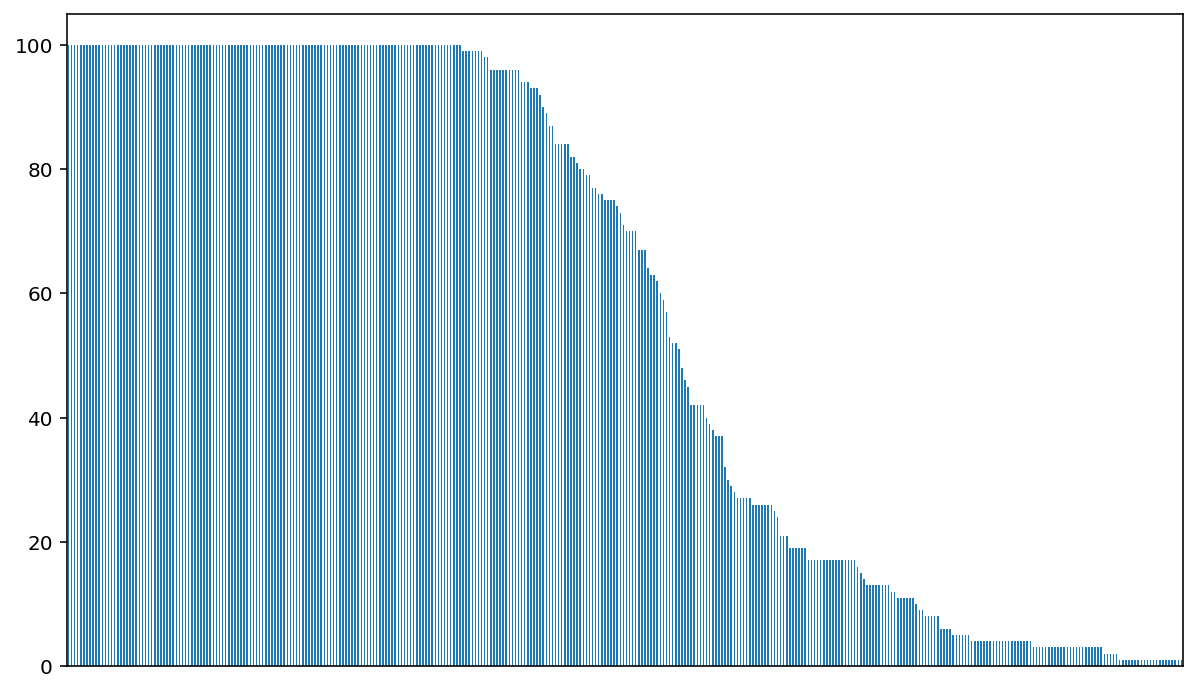

In [9]:
plt.figure(figsize=(10,10))
df_train_raw.cycle.value_counts().plot(kind='bar',figsize=(10,6))
plt.xticks([])
plt.show()

In [10]:
# 테스트 데이터
path2 = 'http://azuremlsamples.azureml.net/templatedata/PM_test.txt'
df_test_raw = pd.read_csv(path2, sep = ' ', header=None)
print(df_test_raw.shape)
df_test_raw.head()

(13096, 28)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN


In [11]:
# 26, 27 열 삭제
df_test_raw.drop([26,27], axis=1, inplace=True)
df_test_raw.columns = col_names

In [12]:
df_test_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 26 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        13096 non-null  int64  
 1   cycle     13096 non-null  int64  
 2   setting1  13096 non-null  float64
 3   setting2  13096 non-null  float64
 4   setting3  13096 non-null  float64
 5   s1        13096 non-null  float64
 6   s2        13096 non-null  float64
 7   s3        13096 non-null  float64
 8   s4        13096 non-null  float64
 9   s5        13096 non-null  float64
 10  s6        13096 non-null  float64
 11  s7        13096 non-null  float64
 12  s8        13096 non-null  float64
 13  s9        13096 non-null  float64
 14  s10       13096 non-null  float64
 15  s11       13096 non-null  float64
 16  s12       13096 non-null  float64
 17  s13       13096 non-null  float64
 18  s14       13096 non-null  float64
 19  s15       13096 non-null  float64
 20  s16       13096 non-null  fl

In [13]:
# 정답 파일 읽기
path3 = 'http://azuremlsamples.azureml.net/templatedata/PM_truth.txt'
df_truth = pd.read_csv(path3, sep = ' ', header=None)
df_truth.head()

,0,1
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [16]:
df_truth.drop([1], axis=1, inplace=True)
df_truth.columns = ['ttf']
df_truth.head()

,ttf
0,112
1,98
2,69
3,82
4,91


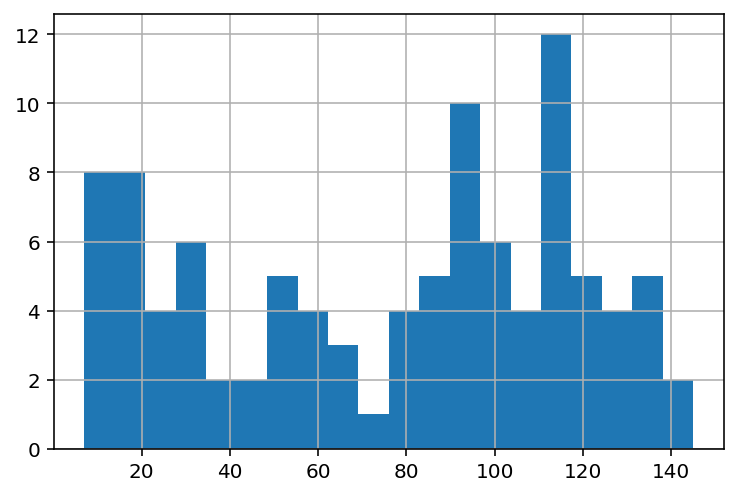

In [17]:
df_truth.ttf.hist(bins=20)

**ground truth 데이터**

*엔진 별로 고장 나기 전에 남아 있는 사이클 수 표시*

테스트 데이터에서서는 언제가 고장난 시점인지 알 수 없다. 


# **레이블 컬럼 추가**
 
 - ttf를 예측하기 위한 레이블 생성
- 분류 기준
 - 이진 분류: 예를 들면, 30 사이클 이내에 고장 여부를 분류
 - 다중 분류: 예를 들면, 30 사이클 이내 및 15 사이클 이내 고장 여부, 또는 정상

In [18]:
df_train = df_train_raw.copy()
df_test = df_test_raw.copy()

# **PreProcessing**



*   rul : remaining meaningful life
*   ttf : time to fail(분류용 레이블)



In [20]:
rul = pd.DataFrame(df_train.groupby('id')['cycle'].max()).reset_index()
rul

,id,cycle
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269
...,...,...
95,96,336
96,97,202
97,98,156
98,99,185


In [21]:
rul.columns = ['id', 'max']
df_train = df_train.merge(rul, on=['id'], how='left')
df_train['ttf'] = df_train['max'] - df_train['cycle']
df_train.drop('max', axis=1, inplace=True)
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


In [22]:
# 분류용 레이블
w1 = 30
w2 = 15
df_train['label_bnc'] = np.where(df_train['ttf'] <= w1, 1, 0 )
df_train['label_mcc'] = df_train['label_bnc']
df_train.loc[df_train['ttf'] <= w2, 'label_mcc'] = 2
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,ttf,label_bnc,label_mcc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


In [23]:
# MinMax scaling
from sklearn.preprocessing import MinMaxScaler
# df_train['cycle_sc'] = df_train['cycle']
cols_sc = df_train.columns.difference(['id','cycle','ttf','label_bnc','label_mcc'])
min_max_scaler = MinMaxScaler()
df_train[cols_sc] = min_max_scaler.fit_transform(df_train[cols_sc])
df_train[:3]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,ttf,label_bnc,label_mcc
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0,0
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0,0
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0,0


In [24]:
# df_test['cycle_sc'] = df_test['cycle']
# transform 사용을 주의 (훈련 데이터와 동일한 min, max 값을 사용하게 함)
df_test[cols_sc] = min_max_scaler.transform(df_test[cols_sc])
df_test[:3]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348


In [25]:
# max 컬럼 생성
rul = pd.DataFrame(df_test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
df_truth.columns = ['more']
df_truth['id'] = df_truth.index + 1
df_truth['max'] = rul['max'] + df_truth['more']
df_truth.drop('more', axis=1, inplace=True)

In [26]:
# ttf 계산
df_test = df_test.merge(df_truth, on=['id'], how='left')
df_test['ttf'] = df_test['max'] - df_test['cycle']
df_test.drop('max', axis=1, inplace=True)
df_test.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,ttf
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,...,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,...,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,...,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,...,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,...,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,138


전처리된 훈련, 테스트 데이터 각각 저장 

In [27]:
df_test.to_csv('PM_test_pre.csv', index=False)
df_train.to_csv('PM_train_pre.csv', index=False)